In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"]=[15,6]
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",50)


In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.shape

(891, 12)

In [4]:
test.shape

(418, 11)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Roadmap

* Univariate Analysis
* Bivariate Analysis- try to find the pattern with the target variable
* Feature Engineering
* Missing values- can deal after feature engineering
* Outlier Identification
* Feature Engineering
* Scaling or Transformation

**Model Building**

* Base Model. In classification, the base model is 0s and in regression, its average

Note: All the Models are submitted using KFold Cross Validation Approach

* Parameter tuning should be done for top 3 models only. Once that is done, we will build the stacking model (Ensemble Model)

Exceptions: LightGBM, CatBoost, ExtraTreesClassifier- can use in competitions 

In [6]:
#before we start lets combine the data

combined= pd.concat([train,test], ignore_index=True)

combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Univariate Analysis

In [7]:
#num data

num_cols=combined.select_dtypes(include=np.number).columns
num_cols

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

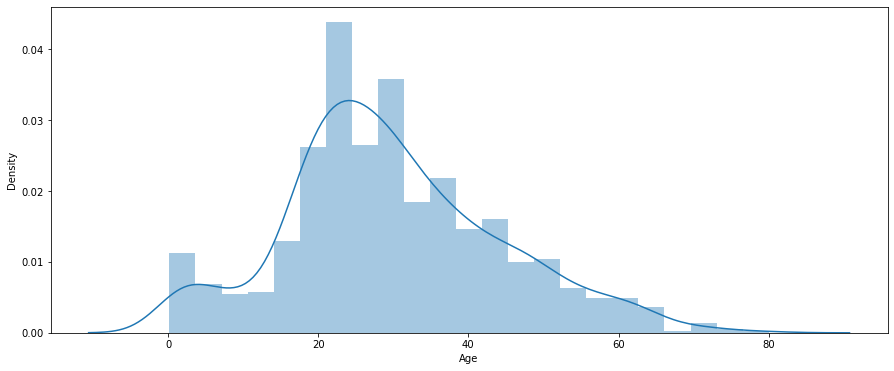

In [8]:
#distplot for age

sns.distplot(combined["Age"])
plt.show()

#The age is skewed, meaning that there were alot of people above 30..

In [9]:
combined.Age.describe()

#mean and median is around 29


count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

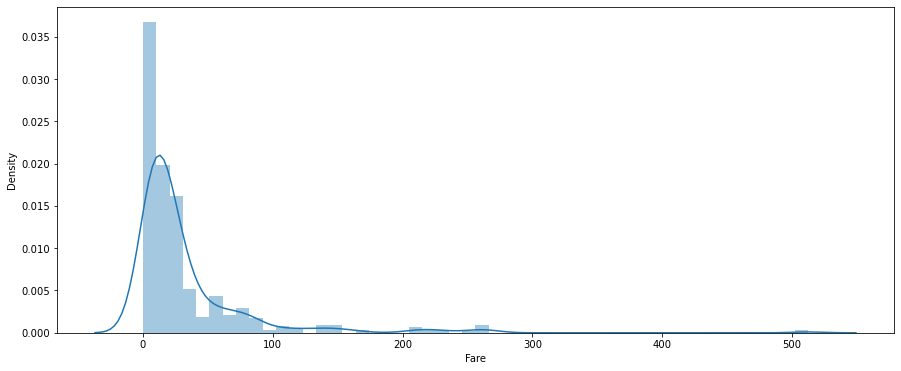

In [10]:
# for fare

sns.distplot(combined["Fare"])
plt.show()

#fare is highly skewed

In [11]:
#cat data

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


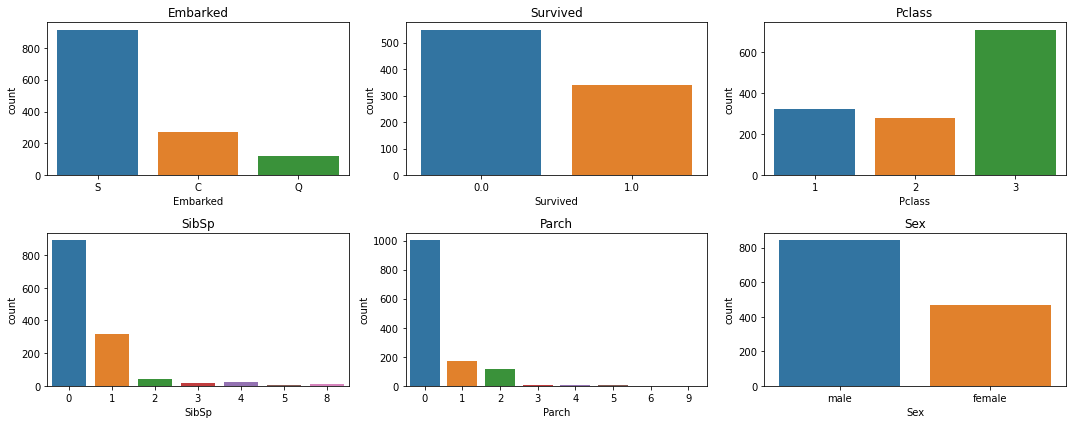

In [12]:
cols=["Embarked", "Survived", "Pclass", "SibSp", "Parch","Sex"]

nrows=2
ncols=3
iterator=1

for i in cols:
    plt.subplot(nrows,ncols, iterator)
    sns.countplot(combined[i])
    plt.title(i)
    iterator+=1
plt.tight_layout()
plt.show()

#Most of the people embarked from southampton, 
#mostly males, 
#were class 3 passengers and 
#travelled alone unfortunately did not survive

### Base Model

In [13]:
#All died

submission= pd.DataFrame({"PassengerId": test["PassengerId"], "Survived":0})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [14]:
submission.to_csv("basemodel.csv", index=False)

In [15]:
# All Females Survived
my_dict= {"male":0, "female":1}

submission= pd.DataFrame({"PassengerId": test["PassengerId"], "Survived":test["Sex"].map(my_dict)})
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [16]:
submission.to_csv("AllFemales.csv", index=False)

### Bivariate Analysis

* num Vs cat

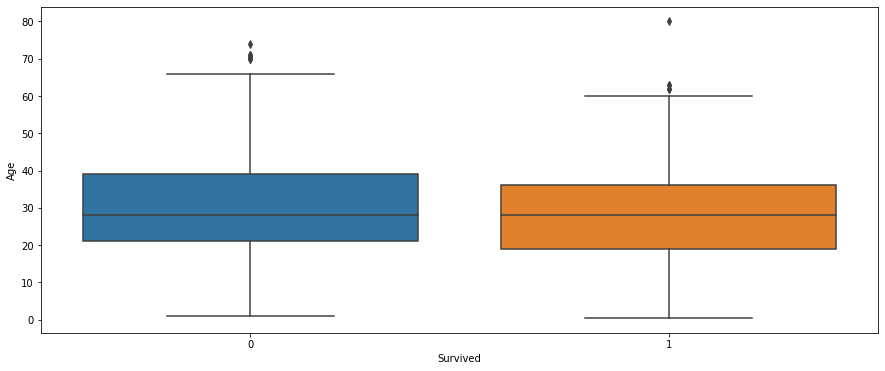

In [17]:
#Age Vs Survived

sns.boxplot(x="Survived", y="Age", data=train)
plt.show()

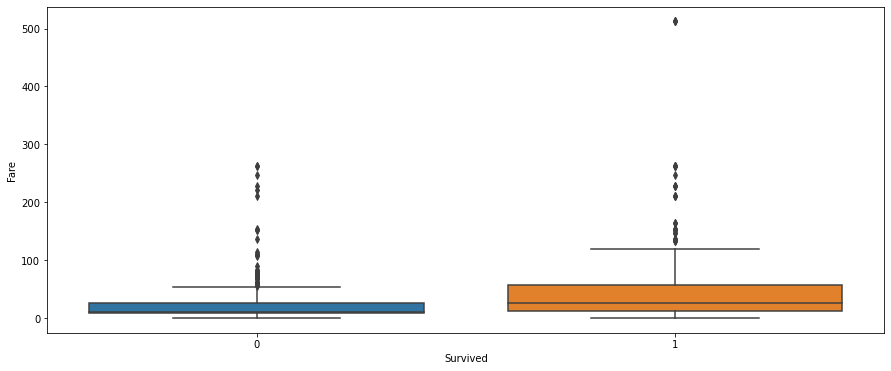

In [18]:
#fare vs survived

sns.boxplot(x="Survived", y="Fare", data=train)
plt.show()
#people who survived paid more fare

In [19]:
#statistical summary 

train.groupby(["Survived"])["Fare"].describe()

# for showing people who survived paid more

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


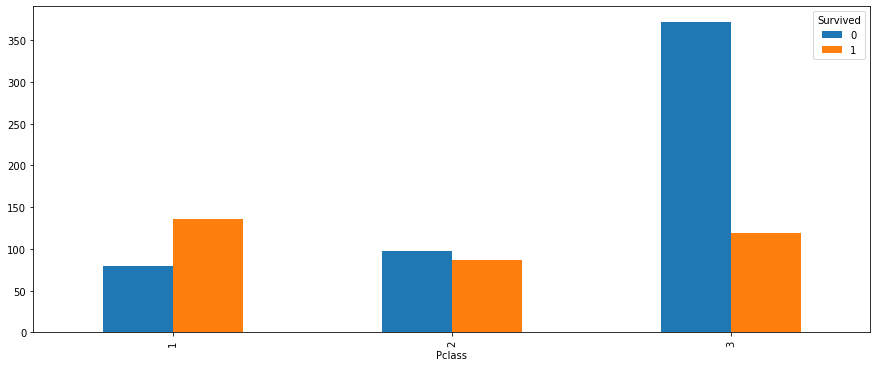

In [20]:
#cat vs Cat

#Pclass Vs Survived

pd.crosstab(train["Pclass"], train["Survived"]).plot(kind="bar")
plt.show()

#class 3 passengers didnt survive, class 1 passengers survived the most

#Class 1 and 2 have a higher survival rate in comp to class 3

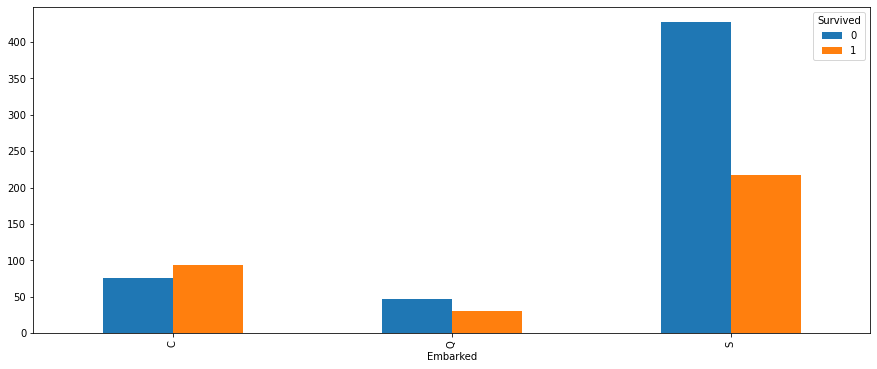

In [21]:
#Embarked Vs Survived

pd.crosstab(train["Embarked"], train["Survived"]).plot(kind="bar")
plt.show()

#cherbourg survival rate is high compared to southampton and queenstown
#cherbourg and southampton people have a higher survival percentage

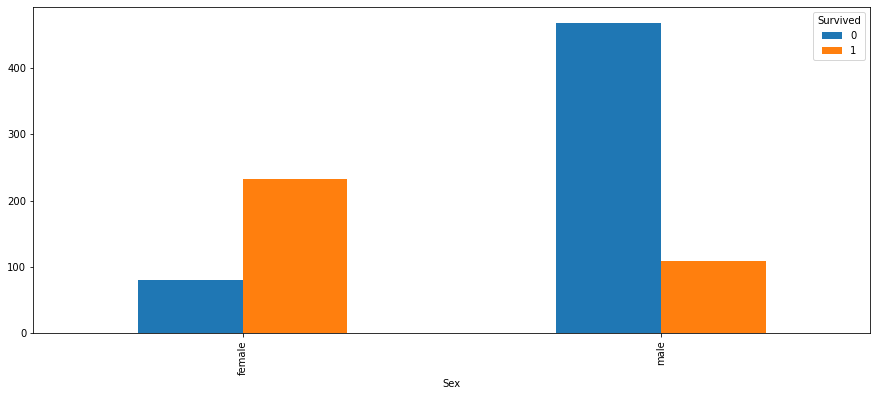

In [22]:
#Gender Vs Survived

pd.crosstab(train["Sex"], train["Survived"]).plot(kind="bar")
plt.show()

#High survival of females in comparison to males..

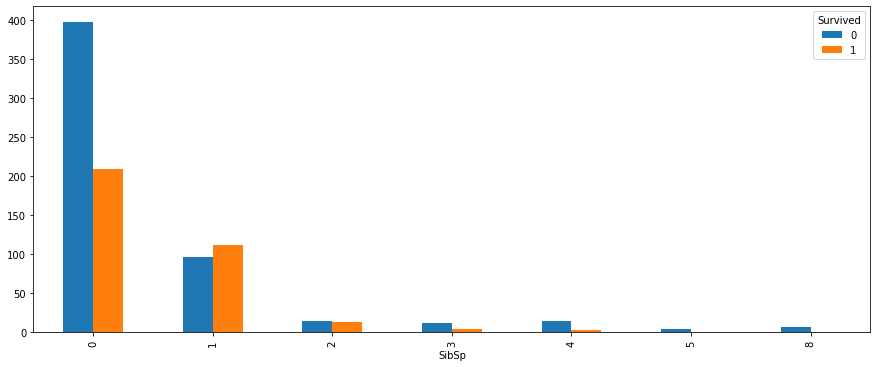

In [23]:
#SibSp Vs Survived

pd.crosstab(train["SibSp"], train["Survived"]).plot(kind="bar")
plt.show()

#travelling solo and single couples- huge chance of survival

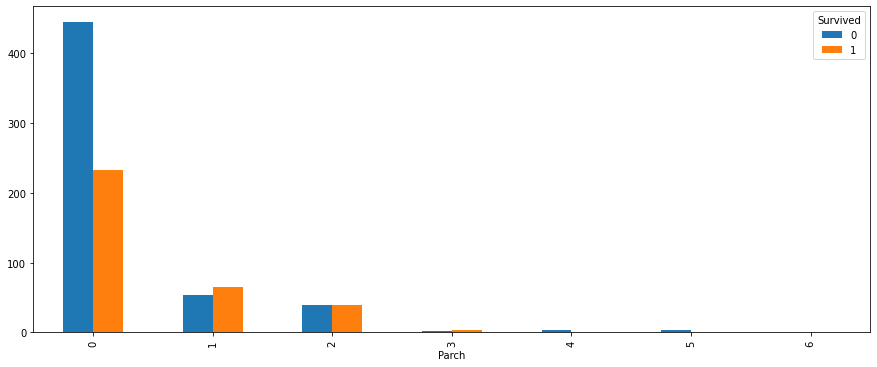

In [24]:
#Parch Vs Survived

pd.crosstab(train["Parch"], train["Survived"]).plot(kind="bar")
plt.show()

#smaller families had a high likelihood of survival

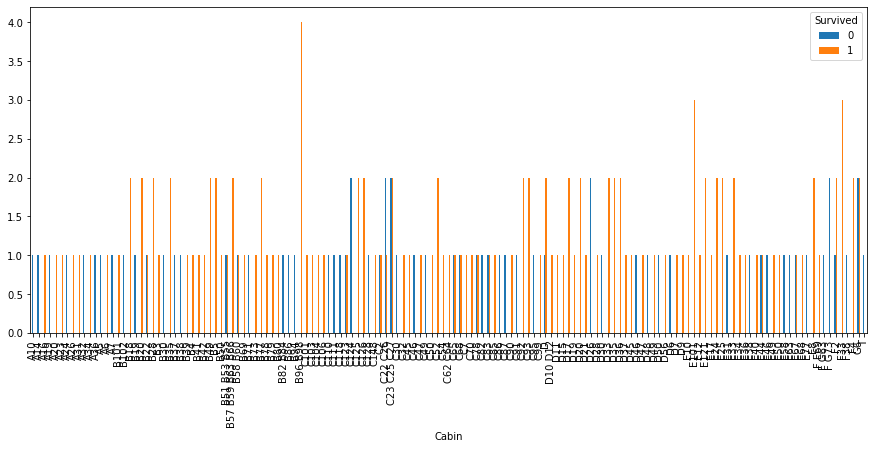

In [25]:
#Cabin Vs Survived

pd.crosstab(train["Cabin"], train["Survived"]).plot(kind="bar")
plt.show()

#lot of cabins- unique values so no interpretation

Inference on Bivariate Analysis:
    
People with class 1 coming from cherbourg or Southampton paid fare more than 28 dollars, female, travelling solo or with 1 person/ kid(s) with and age of 30 or more has a high likelihood of survival

### Missing Values

In [26]:
combined.isnull().sum()[combined.isnull().sum()!=0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

### Feature Engineering

* Cabin

* Age- basis Title from Name 

* Family
* Family Cat

In [27]:
# cabin

combined["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [28]:
cabins=['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46', 'D30',
       'E121', 'D11', 'E77', 'F38', 'B3', 'D6', 'B82 B84', 'D17', 'A36',
       'B102', 'B69', 'E49', 'C47', 'D28', 'E17', 'A24', 'C50', 'B42',
       'C148', 'B45', 'B36', 'A21', 'D34', 'A9', 'C31', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C55 C57', 'C116', 'F', 'A29', 'C6', 'C28',
       'C51', 'C97', 'D22', 'B10', 'E45', 'E52', 'A11', 'B11', 'C80',
       'C89', 'F E46', 'B26', 'F E57', 'A18', 'E60', 'E39 E41',
       'B52 B54 B56', 'C39', 'B24', 'D40', 'D38', 'C105']

In [29]:
def cabin_available(x):
    if x in cabins:
        return("Avbl")
    else:
        return("Miss")

In [30]:
combined["Cabin_cat"]= combined["Cabin"].apply(cabin_available)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Miss
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Avbl
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Avbl
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Miss


<AxesSubplot:xlabel='Cabin_cat'>

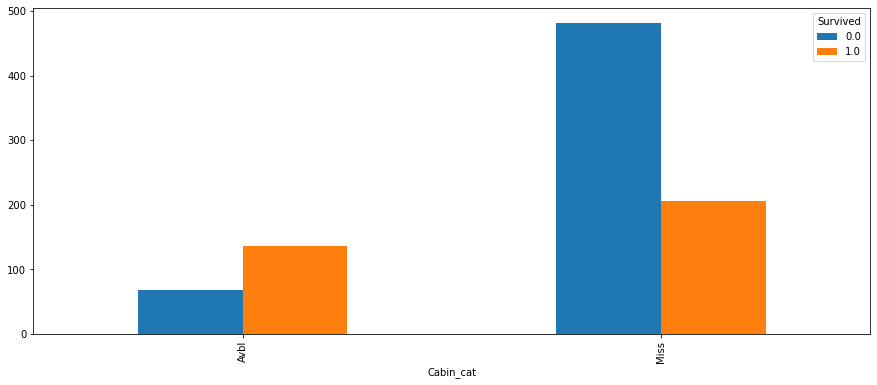

In [31]:
# to see if this variable makes sense

pd.crosstab(combined["Cabin_cat"], combined["Survived"]).plot(kind="bar")

#people who have cabins have higher survival rate

In [32]:
#Age 


#to impute missing values in age with respect to the salutation in name

# name - extract the salutation

combined["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0].unique() #try lambda to deal with this

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [33]:
#by lambda

a=lambda x:x.split(", ")[1].split(".")[0]

combined["Name"].apply(a).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [34]:
combined["Titles"]= combined["Name"].apply(a)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Miss,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Avbl,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Avbl,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Miss,Mr


In [35]:
combined["Titles"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [36]:
#to impute others in all other than Mr, Mrs, miss, Master, Ms for clarity

titles_ignore=['Don', 'Rev', 'Dr', 'Mme',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona']

def mytitles(x):
    if x in titles_ignore:
        return("others")
    else:
        return(x)
    
    
combined["Titles"]=combined["Titles"].apply(mytitles)
combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Miss,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Avbl,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Avbl,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Miss,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Miss,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Avbl,others
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Miss,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Miss,Mr


In [37]:
combined.groupby(["Titles"])["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Titles,,,,,,,,
Master,53.0,5.482642,4.161554,0.33,2.0,4.0,9.0,14.5
Miss,210.0,21.774238,12.249077,0.17,15.0,22.0,30.0,63.0
Mr,581.0,32.252151,12.422089,11.00,23.0,29.0,39.0,80.0
Mrs,170.0,36.994118,12.901767,14.00,27.0,35.5,46.5,76.0
Ms,1.0,28.000000,NaN,28.00,28.0,28.0,28.0,28.0
others,31.0,43.129032,12.309189,23.00,32.5,45.0,52.5,70.0


In [38]:
#imputing age with the titles median

combined.loc[(combined["Titles"]=="Master")& (combined["Age"].isnull()), "Age"]=4
combined.loc[(combined["Titles"]=="Miss")& (combined["Age"].isnull()), "Age"]=22
combined.loc[(combined["Titles"]=="Mr")& (combined["Age"].isnull()), "Age"]=29
combined.loc[(combined["Titles"]=="Mrs")& (combined["Age"].isnull()), "Age"]=36
combined.loc[(combined["Titles"]=="Ms")& (combined["Age"].isnull()), "Age"]=28
combined.loc[(combined["Titles"]=="others")& (combined["Age"].isnull()), "Age"]=45

In [39]:
combined.isnull().sum()[combined.isnull().sum()>0]

Survived     418
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [40]:
#fare


combined[combined["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Miss,Mr


In [41]:
#taking sex, pclass, cabin cat, titles, imputing the fare(wouldve done with the ticket but theres only this person 
#in this ticket)

combined.loc[(combined["Sex"]=="male")&(combined["Titles"]=="Mr")&(combined["Cabin_cat"]=="Miss")&
             (combined["Pclass"]==3), "Fare"].describe()

count    439.000000
mean      11.167623
std       10.074809
min        0.000000
25%        7.750000
50%        7.895800
75%        8.662500
max       69.550000
Name: Fare, dtype: float64

In [42]:
#fare as 7.89 - median

combined.loc[combined["Fare"].isnull(), "Fare"]=7.8958

In [43]:
combined.isnull().sum()[combined.isnull().sum()>0]

Survived     418
Cabin       1014
Embarked       2
dtype: int64

In [44]:
#embarked

combined[combined["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Avbl,Miss
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Avbl,Mrs


In [45]:
#cabin is B28, so we can see the passengers in embarking in ths

combined[combined["Cabin"]=="B28"] # cannot do this because only these 2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Avbl,Miss
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Avbl,Mrs


In [46]:
#to see the fare at which people embarked are more than 80 and Pclass 1

combined.loc[(combined["Fare"]>=80)&(combined["Pclass"]==1), "Embarked"].mode() #to get the highest number of places

0    C
Name: Embarked, dtype: object

In [47]:
#imputing C as it is highest with respect to Pclass 1 and Fare more than 80

combined.loc[combined["Embarked"].isnull(),"Embarked"]="C"

In [48]:
combined.isnull().sum()[combined.isnull().sum()>0]

Survived     418
Cabin       1014
dtype: int64

In [49]:
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Miss,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Avbl,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Avbl,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Miss,Mr


### Feature Engineering

* SibSp and Parch

<AxesSubplot:ylabel='Family'>

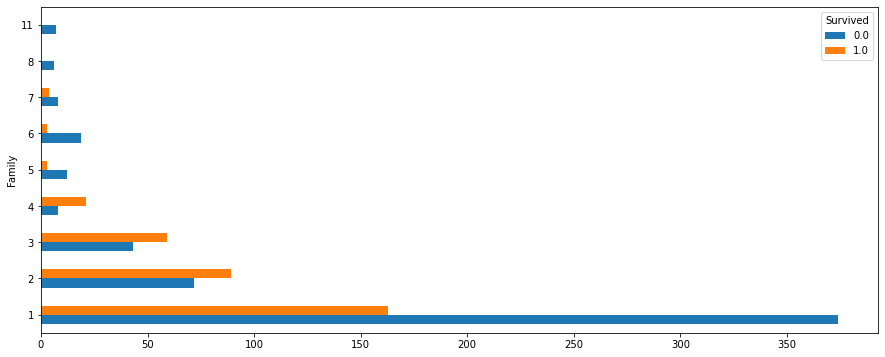

In [50]:
#Family column- combined SibSp and Parch

combined["Family"]= combined["SibSp"].astype("int")+combined["Parch"].astype("int")+1

#pattern of family with survival

pd.crosstab(combined["Family"],combined["Survived"]).plot(kind="barh")

In [51]:
#Family Cat

def fam(x):
    if x==1:
        return("Single")
    if x==2:
        return("Couples")
    if x==3:
        return("Small Family")
    else:
        return("Large Family")

In [52]:
combined["Family_cat"]= combined["Family"].apply(fam)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles,Family,Family_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Miss,Mr,2,Couples
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Avbl,Mrs,2,Couples
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,1,Single
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Avbl,Mrs,2,Couples
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Miss,Mr,1,Single


<AxesSubplot:ylabel='Family_cat'>

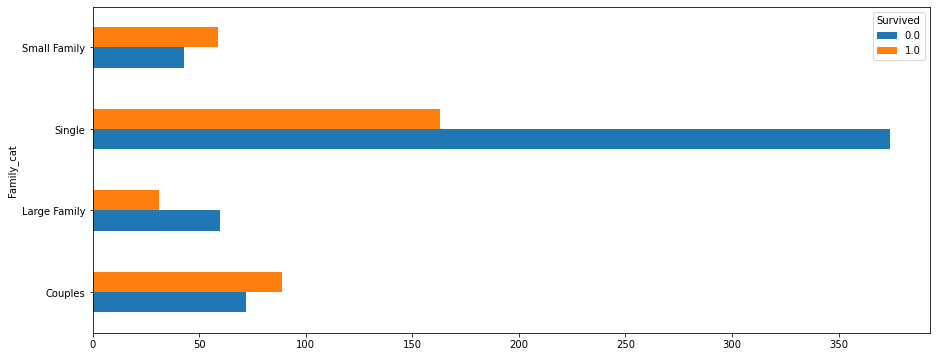

In [53]:
pd.crosstab(combined["Family_cat"],combined["Survived"]).plot(kind="barh")

In [54]:
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat,Titles,Family,Family_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Miss,Mr,2,Couples
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Avbl,Mrs,2,Couples
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,1,Single
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Avbl,Mrs,2,Couples
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Miss,Mr,1,Single


In [55]:
#dropping all redundant variables

new=combined.drop(["Cabin", "Name", "PassengerId", "SibSp", "Parch", "Ticket"], axis=1)
new

,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_cat,Titles,Family,Family_cat
0,0.0,3,male,22.0,7.2500,S,Miss,Mr,2,Couples
1,1.0,1,female,38.0,71.2833,C,Avbl,Mrs,2,Couples
2,1.0,3,female,26.0,7.9250,S,Miss,Miss,1,Single
3,1.0,1,female,35.0,53.1000,S,Avbl,Mrs,2,Couples
4,0.0,3,male,35.0,8.0500,S,Miss,Mr,1,Single
...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,29.0,8.0500,S,Miss,Mr,1,Single
1305,NaN,1,female,39.0,108.9000,C,Avbl,others,1,Single
1306,NaN,3,male,38.5,7.2500,S,Miss,Mr,1,Single
1307,NaN,3,male,29.0,8.0500,S,Miss,Mr,1,Single


# split the data into train and test

In [56]:
#split the data into train and test

train.shape, test.shape

((891, 12), (418, 11))

In [57]:
#pullin the data for train

newtrain = new.iloc[0:train.shape[0], ]
newtrain.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_cat,Titles,Family,Family_cat
0,0.0,3,male,22.0,7.2500,S,Miss,Mr,2,Couples
1,1.0,1,female,38.0,71.2833,C,Avbl,Mrs,2,Couples
2,1.0,3,female,26.0,7.9250,S,Miss,Miss,1,Single
3,1.0,1,female,35.0,53.1000,S,Avbl,Mrs,2,Couples
4,0.0,3,male,35.0,8.0500,S,Miss,Mr,1,Single


In [58]:
#pulling the data for test

newtest = new.iloc[train.shape[0]:, ]
newtest = newtest.drop("Survived", axis=1)
newtest.shape

(418, 9)

# Statistical Tests- 
* to find variables are going well with target or not
* cat vs cat - chi2 contingency
* num vs cat - T test(because binary classifier)

In [59]:
newtrain.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_cat,Titles,Family,Family_cat
0,0.0,3,male,22.0,7.2500,S,Miss,Mr,2,Couples
1,1.0,1,female,38.0,71.2833,C,Avbl,Mrs,2,Couples
2,1.0,3,female,26.0,7.9250,S,Miss,Miss,1,Single
3,1.0,1,female,35.0,53.1000,S,Avbl,Mrs,2,Couples
4,0.0,3,male,35.0,8.0500,S,Miss,Mr,1,Single


In [60]:
newtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Embarked    891 non-null    object 
 6   Cabin_cat   891 non-null    object 
 7   Titles      891 non-null    object 
 8   Family      891 non-null    int32  
 9   Family_cat  891 non-null    object 
dtypes: float64(3), int32(1), int64(1), object(5)
memory usage: 66.3+ KB


In [61]:
#chi square test

#Ho: Predictor is independent of Target- predictor and target are not related
#Ha: Ho is false

cols=["Embarked", "Pclass", "Sex", "Cabin_cat", "Titles", "Family", "Family_cat"]

newtrain["Survived"]=newtrain["Survived"].astype(int)

In [62]:
import scipy.stats as stats

for i in cols:
    tbl=pd.crosstab(newtrain.loc[:,i], newtrain["Survived"])
    teststats,pvalue,df,exp_freq= stats.chi2_contingency(tbl)
    print("Pvalue for", i, "is", np.round(pvalue,10))
    
    
#all the variables are important and are related to target as p value < 0.05

Pvalue for Embarked is 8.294e-07
Pvalue for Pclass is 0.0
Pvalue for Sex is 0.0
Pvalue for Cabin_cat is 0.0
Pvalue for Titles is 0.0
Pvalue for Family is 0.0
Pvalue for Family_cat is 0.0


In [63]:
#two sample Ind Ttest

cols=["Age", "Fare"]

for i in cols:
    zero=newtrain.loc[newtrain["Survived"]==0, i]
    one=newtrain.loc[newtrain["Survived"]==1, i]
    teststats, pvalue= stats.ttest_ind(zero,one)
    print(i,":",pvalue)
    
#both are important

Age : 0.035221475642749966
Fare : 6.120189341924198e-15


### Encoding

In [64]:
newtrain.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Cabin_cat,Titles,Family,Family_cat
0,0,3,male,22.0,7.2500,S,Miss,Mr,2,Couples
1,1,1,female,38.0,71.2833,C,Avbl,Mrs,2,Couples
2,1,3,female,26.0,7.9250,S,Miss,Miss,1,Single
3,1,1,female,35.0,53.1000,S,Avbl,Mrs,2,Couples
4,0,3,male,35.0,8.0500,S,Miss,Mr,1,Single


In [65]:
X = newtrain.drop("Survived", axis=1)
y = newtrain["Survived"]

In [66]:
X=pd.get_dummies(X, drop_first=True)
X.head()

,Pclass,Age,Fare,Family,Sex_male,Embarked_Q,Embarked_S,Cabin_cat_Miss,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Ms,Titles_others,Family_cat_Large Family,Family_cat_Single,Family_cat_Small Family
0,3,22.0,7.2500,2,1,0,1,1,0,1,0,0,0,0,0,0
1,1,38.0,71.2833,2,0,0,0,0,0,0,1,0,0,0,0,0
2,3,26.0,7.9250,1,0,0,1,1,1,0,0,0,0,0,1,0
3,1,35.0,53.1000,2,0,0,1,0,0,0,1,0,0,0,0,0
4,3,35.0,8.0500,1,1,0,1,1,0,1,0,0,0,0,1,0


In [67]:
newtest=pd.get_dummies(newtest, drop_first=True)
newtest.shape, X.shape

((418, 16), (891, 16))

### 

### Model Building

* Logistic Regression
* Random Forest
* Gradient Boosting
* XGBoost
* LightGBM

In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier

In [69]:
# Instantiating the machines for learning

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [70]:
#Logistic Regression Model

lg=LogisticRegression()

pred=[]

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(lg.fit(xtrain,ytrain).predict(newtest))

In [71]:
finalpred = pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,1
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [72]:
#submission

submission["Survived"]= finalpred

In [73]:
submission.to_csv("LogisticModel.csv", index=False) #76.794% accuracy

In [74]:
#Random Forest Model

rf=RandomForestClassifier()

pred=[]

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(rf.fit(xtrain,ytrain).predict(newtest))
    
finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,1
4,1
...,...
413,0
414,1
415,0
416,0


In [75]:
#submission

submission["Survived"]= finalpred
submission.to_csv("RandomForestModel.csv", index=False) #74.4% accuracy

In [76]:
#Random Forest Model

gbm=GradientBoostingClassifier()

pred=[]

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(gbm.fit(xtrain,ytrain).predict(newtest))
    
finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [77]:
#submission

submission["Survived"]= finalpred
submission.to_csv("Gradientboostmodel.csv", index=False) #76.55% accuracy

In [102]:
#Gradient Boosting Model 21 Kfold


kfold=StratifiedKFold(n_splits=21, shuffle=True, random_state=0)

gbm20=GradientBoostingClassifier()

pred = []

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(gbm20.fit(xtrain,ytrain).predict(newtest))

finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [103]:
submission["Survived"]= finalpred
submission.to_csv("Gradientboostmodel20.csv", index=False) #77.03% accuracy

In [105]:
!pip install lightgbm

In [106]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [107]:
#Light GBM


kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

lgbm=LGBMClassifier()

pred = []

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(lgbm.fit(xtrain,ytrain).predict(newtest))

finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,1
4,1
...,...
413,0
414,1
415,0
416,0


In [108]:
submission["Survived"]= finalpred
submission.to_csv("LGBModel.csv", index=False) #75.59% accuracy

In [109]:
xgb=XGBClassifier()

pred = []

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(xgb.fit(xtrain,ytrain).predict(newtest))

finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,1
4,1
...,...
413,0
414,1
415,0
416,0


In [110]:
submission["Survived"]= finalpred
submission.to_csv("XGBModel.csv", index=False) #74.40% accuracy

### Parameter tuning of GBM

In [117]:
from sklearn.model_selection import GridSearchCV

gbm=GradientBoostingClassifier()

params=({"loss":["deviance", "exponential"], "n_estimators":[100,200,500,1000], 
         "criterion":["friedman_mse", "squared_error", "mse"], "min_samples_split":[2,4,6,8], "max_depth":[2,4,6,8]})

grid=GridSearchCV(estimator=gbm, param_grid=params, cv=5)

grid.fit(X,y)

grid.best_params_

{'criterion': 'friedman_mse',
 'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 4,
 'n_estimators': 500}

In [118]:
#Gradient boosting after parameter tuning



gbm2 = GradientBoostingClassifier(loss="deviance",criterion="friedman_mse",
                                  max_depth=2, min_samples_split=4, n_estimators=500)


pred=[]

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(gbm2.fit(xtrain,ytrain).predict(newtest))

finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,1
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [119]:
submission["Survived"]= finalpred
submission.to_csv("GradientBoosting-Para.csv", index=False) #77.51% accuracy

# Stacking Classifier Model

In [121]:
from sklearn.ensemble import StackingClassifier

basemodels=[("lg", lg), ("lgbm", lgbm)]
finalmodel= GradientBoostingClassifier(loss="deviance",criterion="friedman_mse",
                                  max_depth=2, min_samples_split=4, n_estimators=500)

stack= StackingClassifier(estimators=basemodels,final_estimator=finalmodel, cv=5)

pred=[]

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(stack.fit(xtrain,ytrain).predict(newtest))

finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [122]:
submission["Survived"]= finalpred
submission.to_csv("StackingClassifierwithtunedGBM.csv", index=False) #77.03% accuracy

### Parameter tuning of XGBoost

In [124]:
from sklearn.model_selection import GridSearchCV

xgb=XGBClassifier()

params=({"n_estimators":[100,200,500,1000],  
         "max_depth":[2,4,6,8]})

grid=GridSearchCV(estimator=xgb, param_grid=params, cv=5)

grid.fit(X,y)

grid.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [125]:
#XG boosting after parameter tuning



xgb2 = XGBClassifier(max_depth=2, n_estimators=200)


pred=[]

for train_index, test_index in kfold.split(X,y):
    xtrain= X.loc[train_index]
    ytrain= y.loc[train_index]
    pred.append(xgb2.fit(xtrain,ytrain).predict(newtest))

finalpred=pd.DataFrame(pred).T.mode(axis=1)
finalpred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [126]:
submission["Survived"]= finalpred
submission.to_csv("XGB-Para.csv", index=False) #76.315% accuracy